# Regression Models Using Statsmodels

`statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. `statsmodels` supports specifying models using `R-style` formulas. For a complete introduction to the package visit their website (https://www.statsmodels.org/stable/index.html).

Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

Here I attempt to use it on pandas dataframe, build several models, and compare their goodness.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression import predstd

%matplotlib inline

We download the *Guerry* dataset, a collection of historical data used in support of Andre-Michel Guerry’s 1833 Essay on the Moral Statistics of France. The data set is hosted online in comma-separated values format (CSV) by the Rdatasets repository. We could download the file locally and then load it using `read_csv`, but `pandas` takes care of all of this automatically for us:

In [198]:
rdata = sm.datasets.get_rdataset("Guerry", "HistData").data
rdata.dropna(axis=0, subset=None, inplace=True) # only one row has missing values
rdata.sort_values(by='Pop1831', inplace=True)
rdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 4 to 56
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dept             85 non-null     int64  
 1   Region           85 non-null     object 
 2   Department       85 non-null     object 
 3   Crime_pers       85 non-null     int64  
 4   Crime_prop       85 non-null     int64  
 5   Literacy         85 non-null     int64  
 6   Donations        85 non-null     int64  
 7   Infants          85 non-null     int64  
 8   Suicides         85 non-null     int64  
 9   MainCity         85 non-null     object 
 10  Wealth           85 non-null     int64  
 11  Commerce         85 non-null     int64  
 12  Clergy           85 non-null     int64  
 13  Crime_parents    85 non-null     int64  
 14  Infanticide      85 non-null     int64  
 15  Donation_clergy  85 non-null     int64  
 16  Lottery          85 non-null     int64  
 17  Desertion        8

In [88]:
rdata.head()

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,...,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1:Sm,...,22,23,64,79,35,7,1,320.280,5549,129.10
45,48,S,Lozere,7710,5990,27,2040,25157,11092,1:Sm,...,72,45,42,86,5,60,0,283.810,5167,140.35
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1:Sm,...,70,12,37,80,32,29,2,351.399,6925,155.90
63,66,S,Pyrenees-Orientales,6728,7632,31,11644,15167,37843,2:Med,...,67,84,77,11,18,52,5,403.445,4116,157.05
62,65,S,Hautes-Pyrenees,12223,9797,53,6001,12125,148039,2:Med,...,85,75,71,76,20,21,5,386.559,4464,233.03


In [102]:
print(dir(smf))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'gee', 'glm', 'glmgam', 'gls', 'glsar', 'logit', 'mixedlm', 'mnlogit', 'negativebinomial', 'nominal_gee', 'ols', 'ordinal_gee', 'phreg', 'poisson', 'probit', 'quantreg', 'rlm', 'wls']


We want to know whether different components in the 86 French departments are associated with per capita wagers on the Royal Lottery in the 1820s. We need to control for the level of population in each region, and we also want to include a series of dummy variables on the right-hand side of our regression equation to control for unobserved heterogeneity due to wealth, crime propensity, and etc. Let's look at the correlation to see which components are important. 

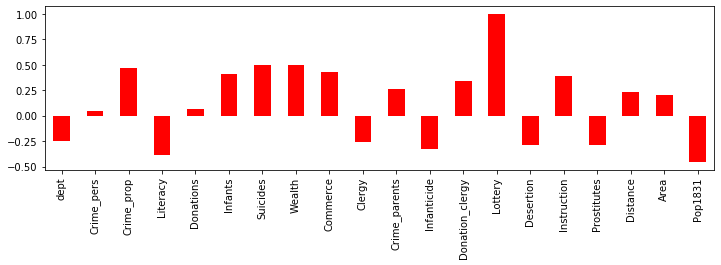

In [202]:
fig = plt.figure(figsize=(12,3))
rdata.corrwith(rdata.Lottery, axis=0, method='pearson').plot(kind='bar', color='r');

## Ordinary least square

The model is estimated using ordinary least squares regression (`smf.ole`). In defining the equation several points need to considered :

- `~` : Separates the left-hand side and right-hand side of a formula. Optional. If not present, then the formula is considered to contain a right-hand side only.
- `+` : Takes the set of terms given on the left and the set of terms given on the right, and returns a set of terms that combines both (i.e., it computes a set union). Note that this means that `a + a` is just a.
- `-` : Takes the set of terms given on the left and removes any terms which are given on the right (i.e., it computes a set difference). `-1` indicates no intercept.
- `*` : `a * b` is short-hand for `a + b + a:b`, and is useful for the common case of wanting to include all interactions between a set of variables while partitioning their variance between lower- and higher-order interactions. Standard ANOVA models are of the form `a * b * c * ...`.
- `/` : This one is a bit quirky. `a / b` is shorthand for `a + a:b`, and is intended to be useful in cases where you want to fit a standard sort of ANOVA model, but `b` is nested within `a`, so `a*b` doesn’t make sense. So far so good. Also, if you have multiple terms on the right, then the obvious thing happens: `a / (b + c)` is equivalent to `a + a:b + a:c` (`/` is rightward distributive over `+`). But, if you have multiple terms on the left, then there is a surprising special case: `(a + b)/c` is equivalent to `a + b + a:b:c` (and note that this is different from what you’d get out of `a/c + b/c` – / is not leftward distributive over `+`). Again, this is motivated by the idea of using this for nested variables. It doesn’t make sense for `c` to be nested within both `a` and `b` separately, unless `b` is itself nested in `a` – but if that were true, then you’d write `a/b/c` instead. So if we see `(a + b)/c`, we decide that `a` and `b` must be independent factors, but that `c` is nested within each combination of levels of `a` and `b`, which is what `a:b:c` gives us. 
- `:` : This takes two sets of terms, and computes the interaction between each term on the left and each term on the right. So, for example, `(a + b):(c + d)` is the same as `a:c + a:d + b:c + b:d`. Calculating the interaction between two terms is also a kind of set union operation, but : takes the union of factors within two terms, while `+` takes the union of two sets of terms. Note that this means that `a:a` is just `a`, and `(a:b):(a:c)` is the same as `a:b:c`.
- `**` : This takes a set of terms on the left, and an integer n on the right, and computes the `*` of that set of terms with itself n times. This is useful if you want to compute all interactions up to order n, but no further. 

For more details see: https://patsy.readthedocs.io/en/latest/formulas.html

In [204]:
formula='Lottery ~ np.log(Crime_prop) + Literacy + np.log(Pop1831) + Wealth*np.log(Suicides) + C(Region)'
olsModel = smf.ols(formula=formula, data=rdata)
olsRes = olsModel.fit()
print(olsRes.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     8.463
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           5.04e-09
Time:                        18:18:27   Log-Likelihood:                -360.42
No. Observations:                  85   AIC:                             742.8
Df Residuals:                      74   BIC:                             769.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Alternative**: The `patsy` module provides a convenient function to prepare design matrices using R-like formulas. You can find more information at https://patsy.readthedocs.io/en/latest/

We use patsy’s dmatrices function to create design matrices:

In [205]:
from patsy import dmatrices

Y, X = dmatrices(formula, data=rdata, return_type='dataframe')

olsModel = sm.OLS(Y, X)
olsRes = olsModel.fit()
print(olsRes.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     8.463
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           5.04e-09
Time:                        18:19:31   Log-Likelihood:                -360.42
No. Observations:                  85   AIC:                             742.8
Df Residuals:                      74   BIC:                             769.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Usually the upper case functions like `sm.OLE` act on design matrices while lower case ones like `smf.ols` accept the raw dataframe.

In [206]:
print('parameters: ', olsRes.params)
print('adjusted R2: ', olsRes.rsquared_adj)

parameters:  Intercept                  71.830156
C(Region)[T.E]             -1.468561
C(Region)[T.N]             15.208539
C(Region)[T.S]             -7.322784
C(Region)[T.W]              2.895363
np.log(Crime_prop)          6.924598
Literacy                   -0.300238
np.log(Pop1831)           -32.095674
Wealth                     -0.100389
np.log(Suicides)            9.955611
Wealth:np.log(Suicides)     0.023838
dtype: float64
adjusted R2:  0.47045881100641807


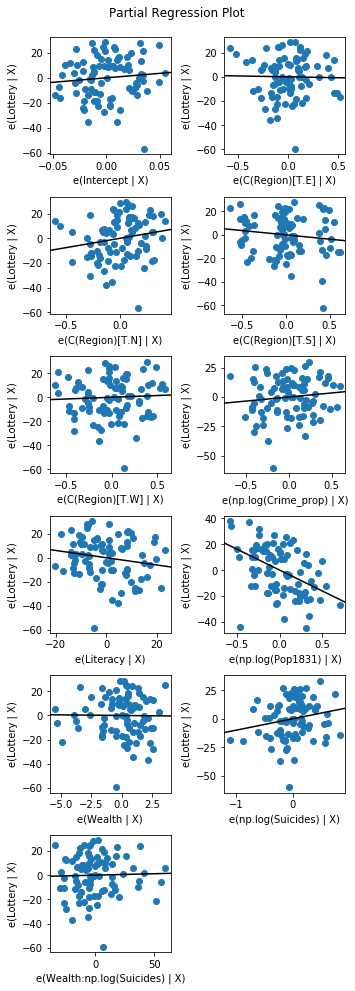

In [211]:
fig = plt.figure(figsize=(5,14))
sm.graphics.plot_partregress_grid(olsRes, fig=fig);

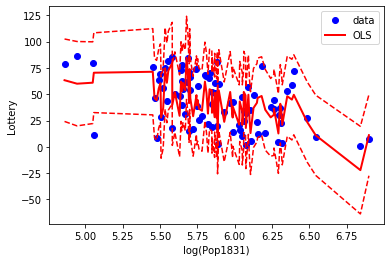

In [212]:
prestd, int_low, int_up = predstd.wls_prediction_std(olsRes)

fig, ax = plt.subplots()
ax.plot(np.log(rdata.Pop1831), rdata.Lottery, 'bo', label='data')
ax.plot(np.log(rdata.Pop1831), olsRes.fittedvalues, 'r-', lw=2, label='OLS')
ax.plot(np.log(rdata.Pop1831), int_low, 'r--')
ax.plot(np.log(rdata.Pop1831), int_up, 'r--')
ax.legend()
ax.set_xlabel('log(Pop1831)')
ax.set_ylabel('Lottery');

## Weighted least square

Even though we don't have any evidence for weighted least sqaure, I attempt to fit data with a weighted least square using some arbitrary weights:

In [213]:
w = 1 + np.log(rdata.dept - rdata.dept.min() + 1)
wlsModel = smf.wls(formula=formula, weights=w, data=rdata)
wlsRes = wlsModel.fit()
print(wlsRes.summary())

                            WLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.518
Model:                            WLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     7.968
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           1.46e-08
Time:                        18:33:51   Log-Likelihood:                -362.77
No. Observations:                  85   AIC:                             747.5
Df Residuals:                      74   BIC:                             774.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

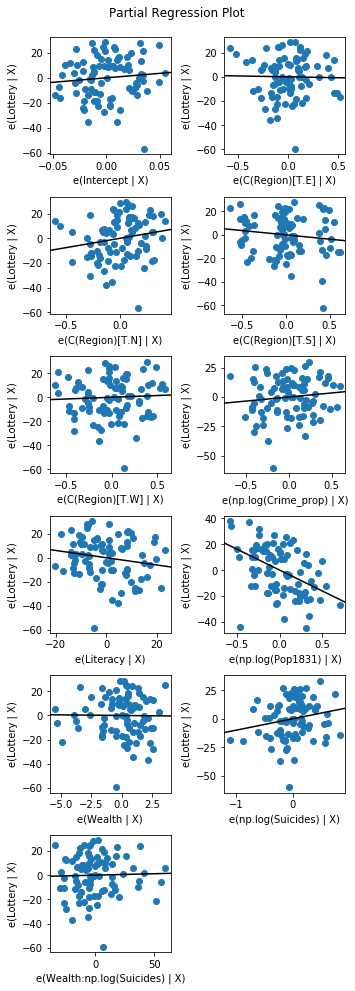

In [216]:
fig = plt.figure(figsize=(5,14))
sm.graphics.plot_partregress_grid(wlsRes, fig=fig);

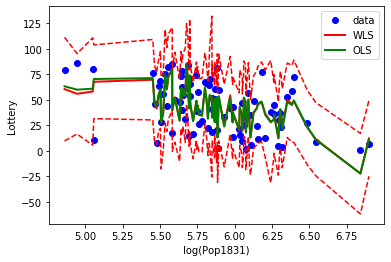

In [217]:
pstd, int_low, int_up = predstd.wls_prediction_std(wlsRes)

fig, ax = plt.subplots()
ax.plot(np.log(rdata.Pop1831), rdata.Lottery, 'bo', label='data')
ax.plot(np.log(rdata.Pop1831), wlsRes.fittedvalues, 'r-', lw=2, label='WLS')
ax.plot(np.log(rdata.Pop1831), olsRes.fittedvalues, 'g-', lw=2, label='OLS')
ax.plot(np.log(rdata.Pop1831), int_low, 'r--')
ax.plot(np.log(rdata.Pop1831), int_up, 'r--')
ax.legend()
ax.set_xlabel('log(Pop1831)')
ax.set_ylabel('Lottery');

## General least square

In [218]:
glsModel = smf.gls(formula=formula, data=rdata)
glsRes = glsModel.fit()
print(glsRes.summary())

                            GLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.533
Model:                            GLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     8.463
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           5.04e-09
Time:                        18:38:08   Log-Likelihood:                -360.42
No. Observations:                  85   AIC:                             742.8
Df Residuals:                      74   BIC:                             769.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

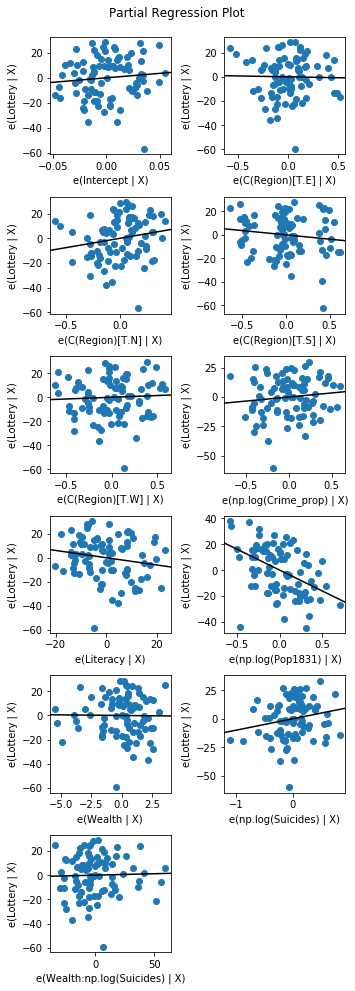

In [230]:
fig = plt.figure(figsize=(5,14))
sm.graphics.plot_partregress_grid(glsRes, fig=fig);

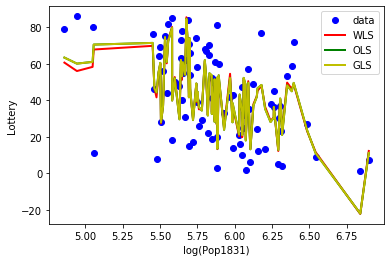

In [224]:
fig, ax = plt.subplots()
ax.plot(np.log(rdata.Pop1831), rdata.Lottery, 'bo', label='data')
ax.plot(np.log(rdata.Pop1831), wlsRes.fittedvalues, 'r-', lw=2, label='WLS')
ax.plot(np.log(rdata.Pop1831), olsRes.fittedvalues, 'g-', lw=2, label='OLS')
ax.plot(np.log(rdata.Pop1831), glsRes.fittedvalues, 'y-', lw=2, label='GLS')
ax.legend()
ax.set_xlabel('log(Pop1831)')
ax.set_ylabel('Lottery');

## Robust least square

In [225]:
rlmModel = smf.rlm(formula=formula, data=rdata, M=sm.robust.norms.HuberT())
rlmRes = rlmModel.fit()
print(rlmRes.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                Lottery   No. Observations:                   85
Model:                            RLM   Df Residuals:                       74
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 22 Jun 2020                                         
Time:                        18:44:27                                         
No. Iterations:                    11                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

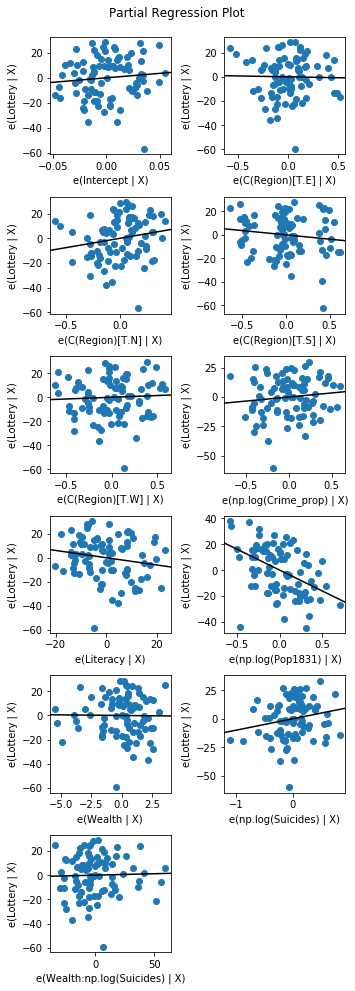

In [231]:
fig = plt.figure(figsize=(5,14))
sm.graphics.plot_partregress_grid(rlmRes, fig=fig);

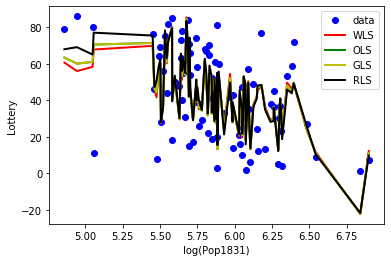

In [228]:
fig, ax = plt.subplots()
ax.plot(np.log(rdata.Pop1831), rdata.Lottery, 'bo', label='data')
ax.plot(np.log(rdata.Pop1831), wlsRes.fittedvalues, 'r-', lw=2, label='WLS')
ax.plot(np.log(rdata.Pop1831), olsRes.fittedvalues, 'g-', lw=2, label='OLS')
ax.plot(np.log(rdata.Pop1831), glsRes.fittedvalues, 'y-', lw=2, label='GLS')
ax.plot(np.log(rdata.Pop1831), rlmRes.fittedvalues, 'k-', lw=2, label='RLS')
ax.legend()
ax.set_xlabel('log(Pop1831)')
ax.set_ylabel('Lottery');